# import libaries

In [1]:
# Manpulate
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Feature Extraction
import user_agents # get info from user_agent (browser_info)
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo # get location from ip
from geopy.distance import great_circle # distance btn 2 (lat,long)
from geopy.geocoders import Nominatim # geocode("place") / reverse("lat,long")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # text feature

In [2]:
# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling

In [3]:
from category_encoders import BinaryEncoder # Nominal Encoding 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling

# load data

In [4]:
df_bank = pd.read_csv("Churn_Modelling.csv" , index_col = "RowNumber")
df_bank

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [5]:
# b) check dtype -> df[col].astype()
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10002 non-null  int64  
 1   Surname          10002 non-null  object 
 2   CreditScore      10002 non-null  int64  
 3   Geography        10001 non-null  object 
 4   Gender           10002 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure           10002 non-null  int64  
 7   Balance          10002 non-null  float64
 8   NumOfProducts    10002 non-null  int64  
 9   HasCrCard        10001 non-null  float64
 10  IsActiveMember   10001 non-null  float64
 11  EstimatedSalary  10002 non-null  float64
 12  Exited           10002 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 1.1+ MB


# 1) Understanding Data
a) Understand Columns
b) check dtype ->df[col].astype()
c) Describe Numerical Cols
d) Describe Categorical Cols

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides
- Gender: The customer's gender
- Age: The customer's age
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card
- IsActiveMember: Whether the customer is an active member
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (Target Variable)

In [6]:
#Customer ID
#It is not an important feature, we will drop it

In [7]:
df_bank.drop('CustomerId', axis=1, inplace=True)
df_bank.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,
1,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
2,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
3,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
4,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [8]:
# c) Describe Numerical Cols
df_bank.describe().style.format("{:.6f}")
df_bank.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10002.000000,10001.000000,10002.000000,10002.000000,10002.000000,10001.000000,10001.000000,10002.000000,10002.000000
mean,650.555089,38.922311,5.012498,76491.112875,1.530194,0.705529,0.514949,100083.331145,0.203759
std,96.661615,10.487200,2.891973,62393.474144,0.581639,0.455827,0.499801,57508.117802,0.402812
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50983.750000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100185.240000,0.000000
75%,718.000000,44.000000,7.000000,127647.840000,2.000000,1.000000,1.000000,149383.652500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


- Statistics of the data in the dataframe for each feature:-
    
- CreditScore: In this dataset, the minimum credit score is 350.0 and the maximum is 850.0.

- Age: In this dataset, the minimum age is 18.0, the maximum is 92.0, and 50% of the people are 37.0 years old.

- Tenure: In this dataset, the minimum tenure is 0.0 years, the maximum is 10.0 years, and 50% of the people have a tenure of 5.0 years.

- Balance: In this dataset, the minimum balance is 0.0, and the maximum is 2,50,898.0

- NumOfProducts: In this dataset, the minimum number of products is 1.0, the maximum is 4.0, and 50% of the people have 2.0 products.

- HasCrCard: In this dataset, 50% of the people have a credit card.

- IsActiveMember: In this dataset, 50% of the people are not active in their accounts.

- Exited: In this dataset, 50% of the people have not left the bank.

In [9]:
display(df_bank.describe(include='object'))

,Surname,Geography,Gender
count,10002,10001,10002
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5458


In [10]:
# d) Describe Categorical Cols
cat_cols = df_bank.select_dtypes(include="O").columns
cat_cols

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [11]:
for col in cat_cols:
    print(f"number of uniques in \"{col}\": {df_bank[col].nunique()}")
    print(f"uniques in \"{col}\":\n{df_bank[col].unique()}")
    print() 

number of uniques in "Surname": 2932
uniques in "Surname":
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

number of uniques in "Geography": 3
uniques in "Geography":
['France' 'Spain' nan 'Germany']

number of uniques in "Gender": 2
uniques in "Gender":
['Female' 'Male']



In [12]:
# Check unique values for categorical columns
categorical_cols = df_bank.select_dtypes(include=['object']).columns
unique_counts = {col: df_bank[col].nunique() for col in categorical_cols}
unique_counts

{'Surname': 2932, 'Geography': 3, 'Gender': 2}

In [13]:
# To change the target column values numerical to categorical
df_bank['Exited'].replace([0, 1],['No','Yes'], inplace=True)

--


2) EXTRACT FEATURES + EDA (uni - bi(heatmap) - multi) -> Insights:
-Uni-variate Analysis

-Histogram (values)
 -distplot (distrbution)
 -catigorical (pie / count)
 
-Bi-Variate Analysis
 -Num vs Num
   -Scatter (relationship btn 2 variables)
   -line (trend with time)
 
-Num vs Cat (distrbution)
 -box
 -violin
 -strip

-Cat vs Cat
 -bar (estimate plot)
 -countplot (count rows)
 
-Multi-Variate Analysis
 -Pairplot

In [14]:
df_bank['Exited'].value_counts()


No     7964
Yes    2038
Name: Exited, dtype: int64

# Count of Exited Customers(target var)

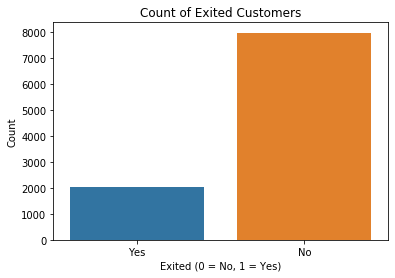

In [15]:
sns.countplot(x='Exited', data=df_bank)
plt.title('Count of Exited Customers')
plt.xlabel('Exited (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [16]:
#Comment: We have an imbalanced case

# plotting the distirbutions of the categorical variables

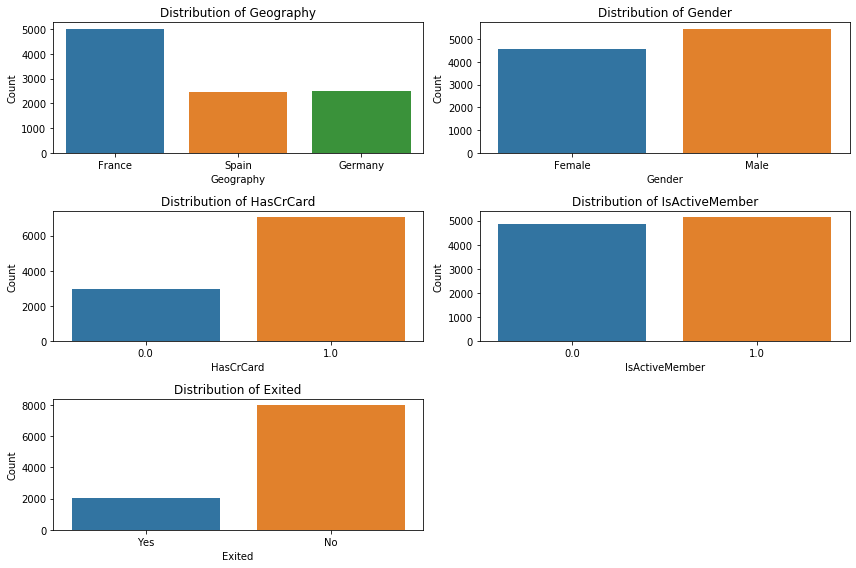

In [17]:
# List of categorical variables
categorical_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

# Set the size of the plots
plt.figure(figsize=(12, 8))

# Loop through each categorical variable and create a count plot
for i, var in enumerate(categorical_vars):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each variable
    sns.countplot(x=var, data=df_bank)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

# plotting the distributions of the numerical variables


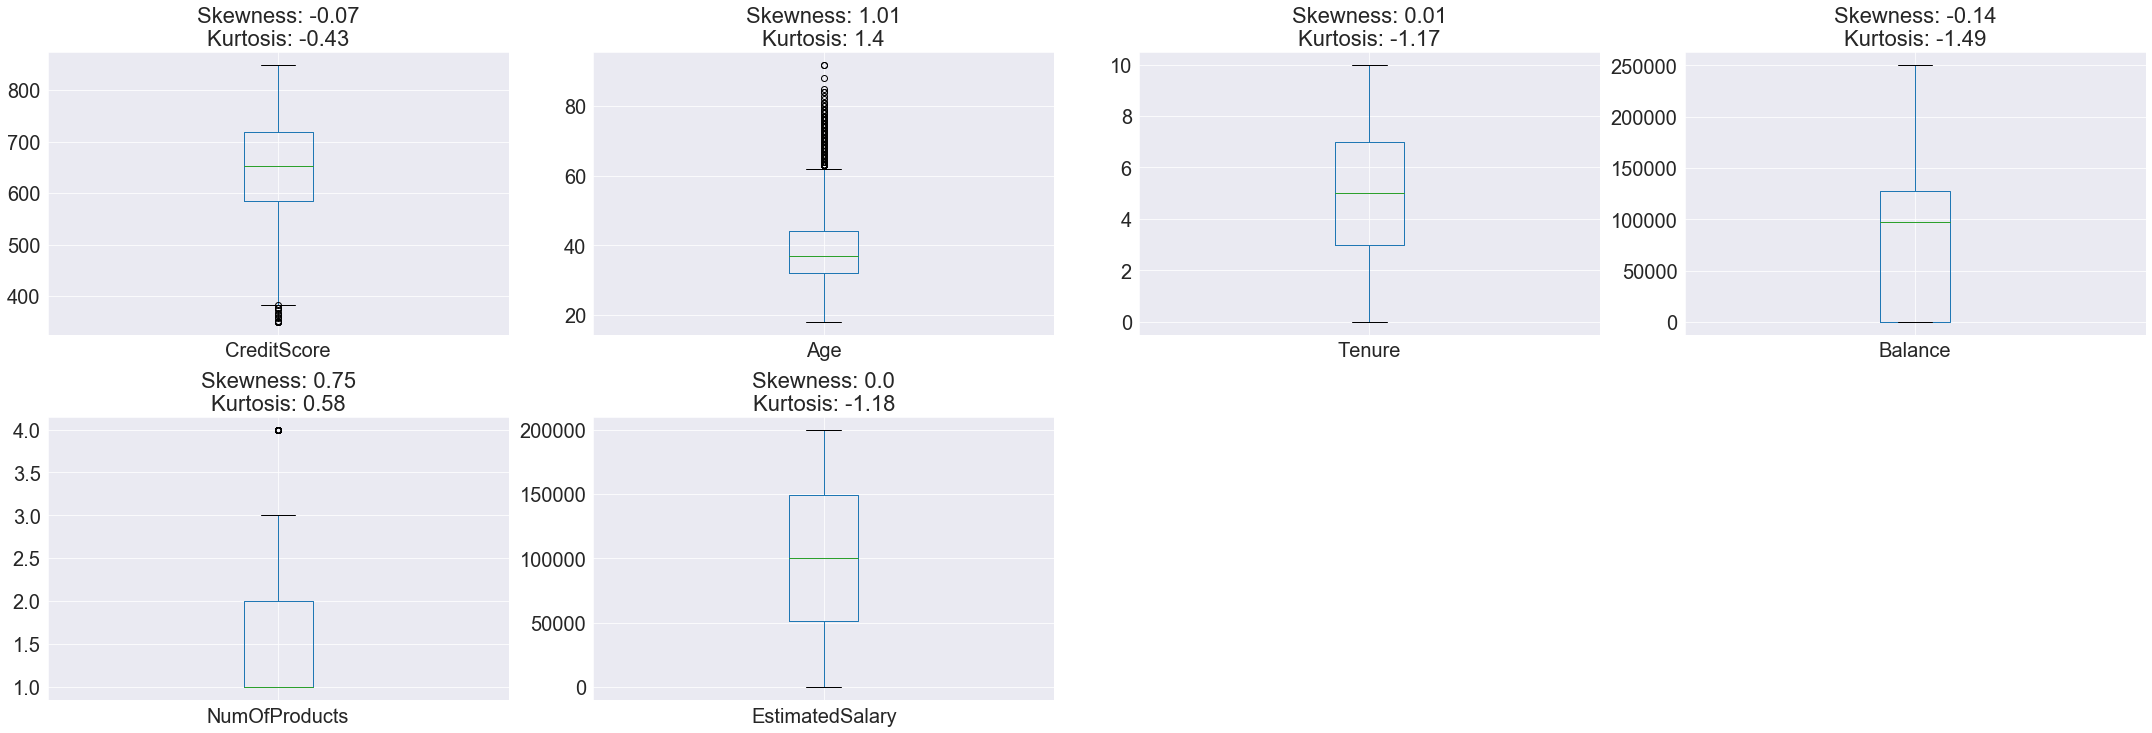

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# the style of seaborn
sns.set_style("darkgrid")

# Create box plots for each numerical feature
plt.figure(figsize=(30, 15))
for i, col in enumerate(num_feats):
    plt.subplot(3, 4, i + 1)
    df_bank[[col]].boxplot(fontsize=20)
    plt.title(f'Skewness: {np.round(df_bank[col].skew(), 2)}\nKurtosis: {np.round(df_bank[col].kurt(), 2)}',
              fontdict={'fontsize': 22})

plt.tight_layout()
plt.savefig("cont_variables.png")
plt.show()

The numbers indicate how skewed the data is, 0 means perfectly normal, 
positive values indicate right skewed and negative values indicate left skewed dataset.

We see it is heavily skewed, especially Age, Balance, NumOfProducts, CreditScore. 

For the “Age” column, there are several outliers, namely the age of the customer over 71 (senior). 
The next question is: do these seniors really have the ability to leave the bank? Based on the results of the examination, it turns out that the majority of seniors chose to remain as bank customers, i.e. 
122 seniors stayed and 11 seniors left the bank. It is interesting to look at this comparison when compared to the overall data, where the ratio of customers leaving the bank (exiting) is 4:1 compared to customers staying.
This indicates that seniors have a greater tendency to remain bank customers than other age groups.
So my suspicions that more and more seniors are leaving banks are unfounded.

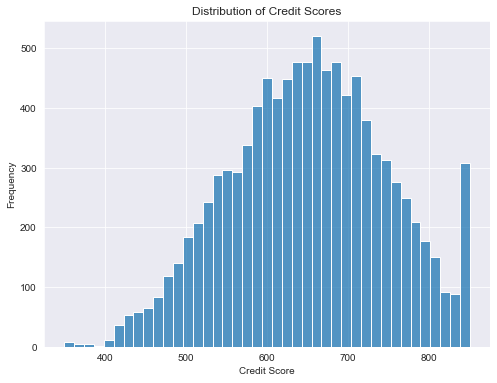

In [19]:
data = df_bank

plt.figure(figsize=(8, 6))
sns.histplot(data['CreditScore'])
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Scores')
plt.show()


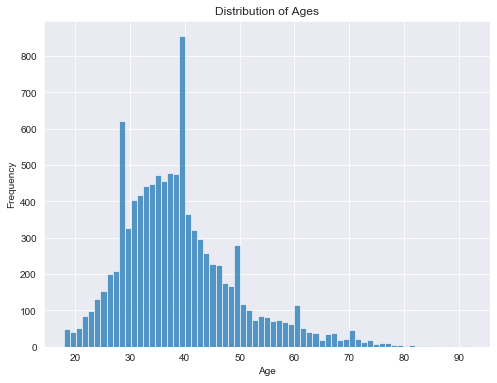

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')
plt.show()

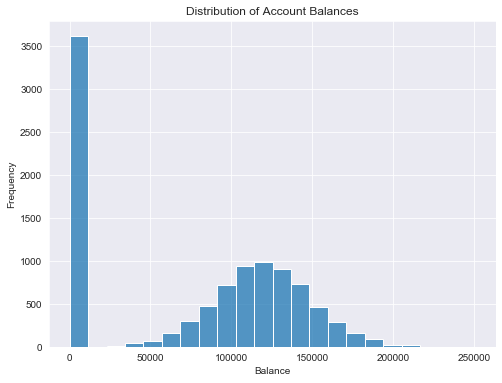

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(df_bank['Balance'])
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Distribution of Account Balances')
plt.show()


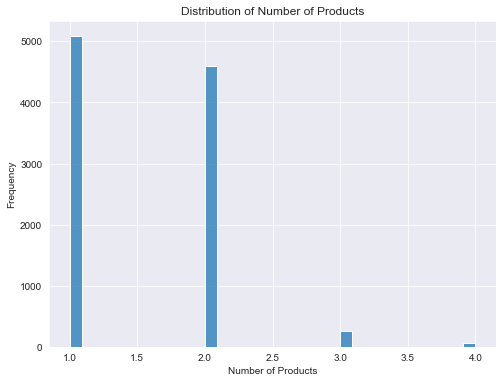

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data['NumOfProducts'])
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Products')
plt.show()

We see how varied the distributions are, and all of them are skewed. 
Out of the features shown above, we will go ahead and fix Age and Credit Scores In order to fix skewness

# Checking Correlation

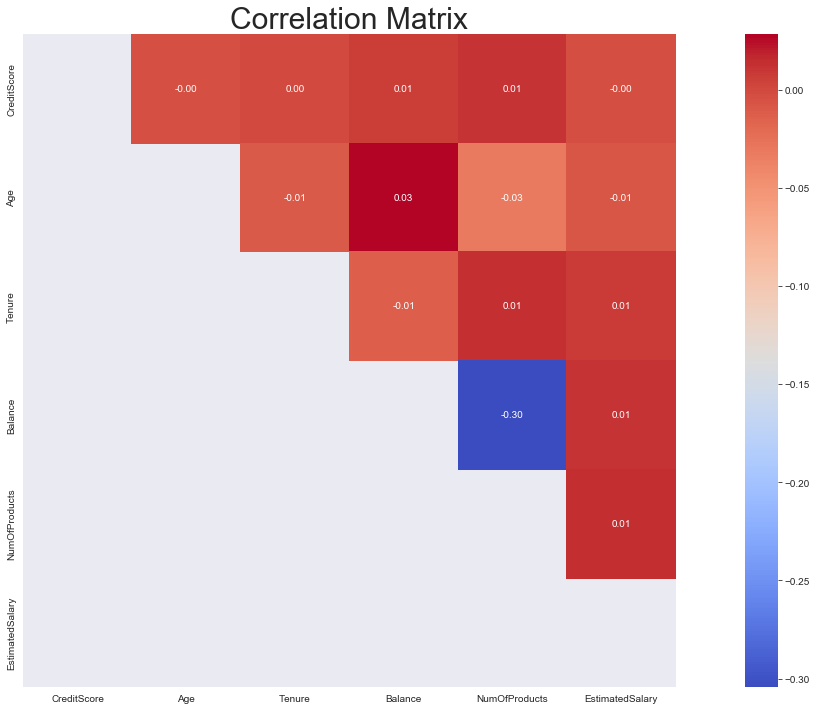

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# List of numerical features
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Calculate the correlation matrix
corr = df_bank[num_feats].corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 12))
mask = np.tril(np.ones_like(corr, dtype=bool))  # Create a mask for the lower triangle

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, square=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=30)
plt.show()

-CreditScore and Balance (0.50): There is a moderate positive correlation, indicating that customers with higher credit scores tend to have higher balances.


-Age and Exited (-0.25): A moderate negative correlation suggests that older customers are somewhat less likely to exit.


-CreditScore and Exited (-0.20): A weak negative correlation indicates that there’s a slight tendency for customers with lower credit scores to exit.

We see high co-relation for certain features like: age, gender, activemember, balance.

Based on out EDA, we had some features in common. Let us use two formal Feature Selection techniques and conclude the selection of features for model training.

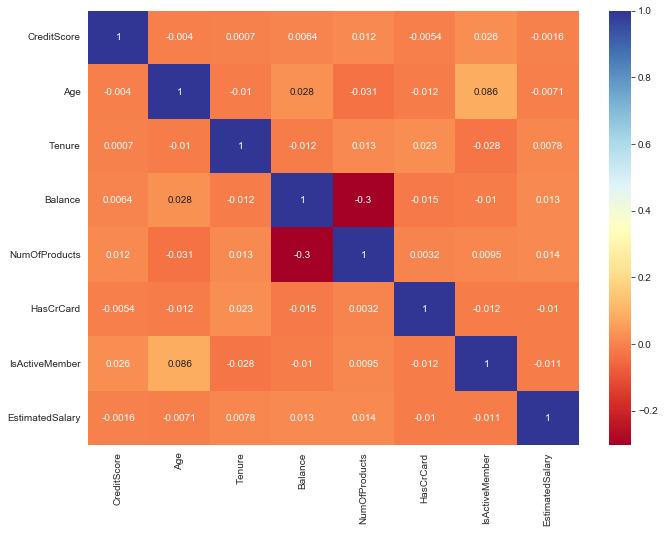

In [24]:
plt.subplots(figsize=(11,8))
sns.heatmap(df_bank.corr(), annot=True, cmap="RdYlBu")
plt.show()

We can see here that there is a strong positive correlation between the Age and the churn, which means that when the age is larger, the possibility of churn is larger, which can tell us that as a person gets older it's more probable that they will chur.

Also we can see a strong negative correlation this time between the (Number of Products and Is active member) with the exited probability, which tells us that when a person is more active the probability of them exiting is low, also when a client has more products in the bank, they are less probable to churn.

From this we can see that these two variables are strongly important in the decision of the probability of a customer churn.

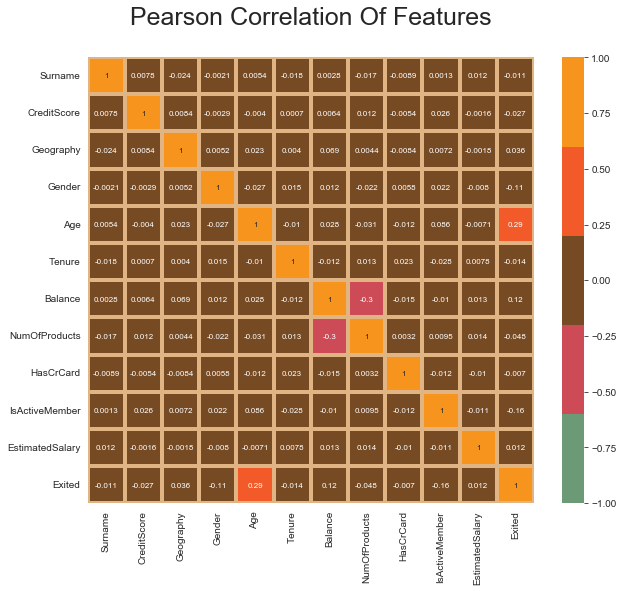

In [25]:
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]
df_corr = df_bank.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(df_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =8))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Target variable vs categorical predictors


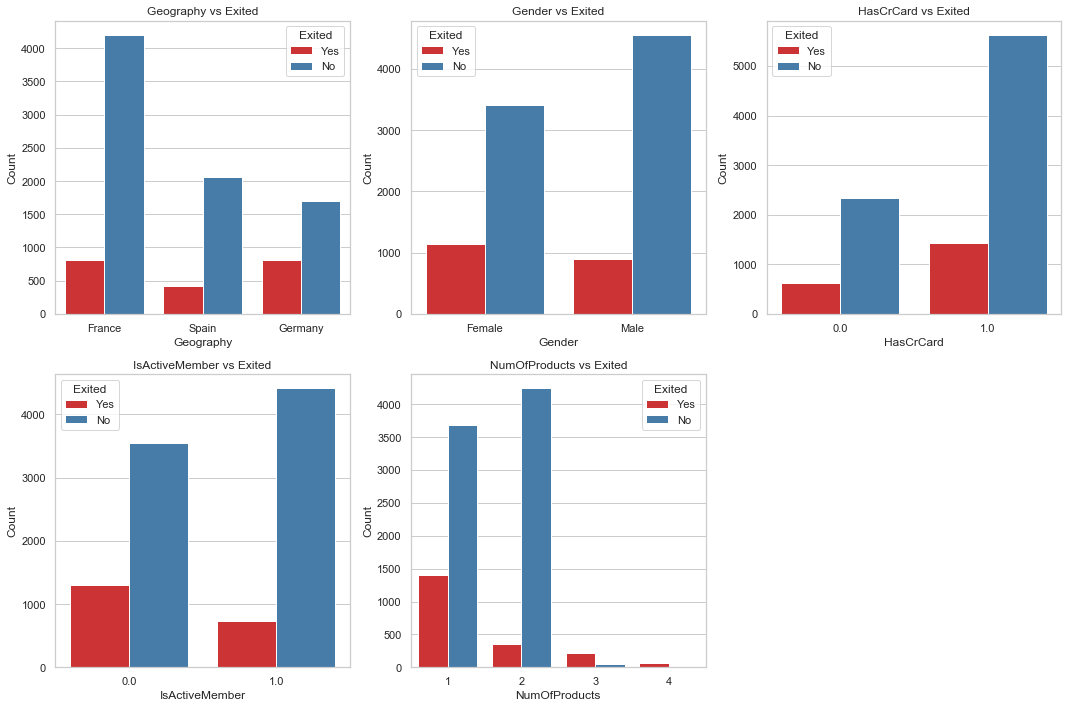

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical predictors
categorical_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Set the style of seaborn
sns.set(style="whitegrid")

# Create count plots for each categorical variable against 'Exited'
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=var, hue='Exited', data=df_bank, palette='Set1')
    plt.title(f'{var} vs Exited')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



note:
-We can see that the odds ratio for customers that exited vs not exited is higher in Germany,
meaning that Geography can help us understand some of the reason for customer churn.
-We can see that the odds ratio for customers that exited vs not exited is higher in the female group (Gender), meaning that Gender can help us understand some of the reason for customer churn (More women leave the bank).

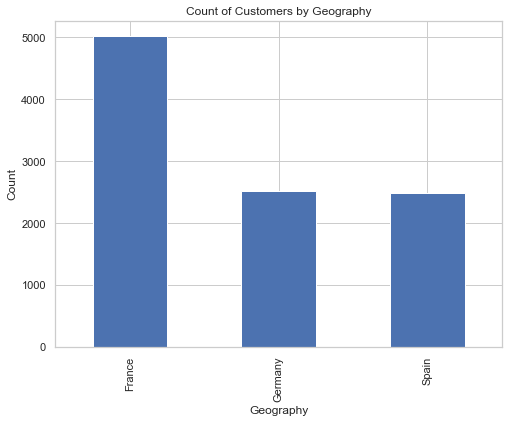

In [27]:
plt.figure(figsize=(8, 6))
df_bank['Geography'].value_counts().plot(kind='bar')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.title('Count of Customers by Geography')
plt.show()

The Graphs on Geography and various features suggest that, we have data more for France as compared to Spain and Germany.

No matter how the Geographic distribution is, we see that the Credit Score for all the three countries is more or less the 

same. We even check who exited and who did not for all the three countries, and that shows some difference. This means, 

using Geography as a feature in the model might be a good idea.

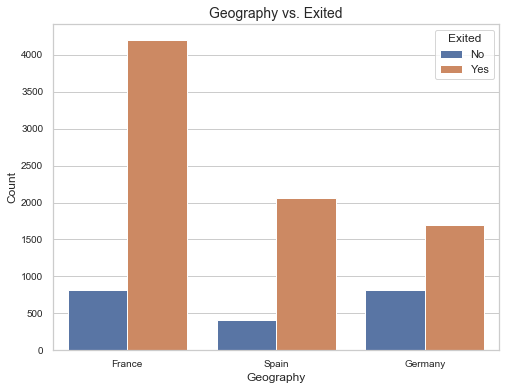

In [28]:
# Count Plot - Geography vs. Exited
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', hue='Exited', data=df_bank)
plt.xlabel('Geography', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Geography vs. Exited', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(title='Exited', labels=['No', 'Yes'])
plt.show()

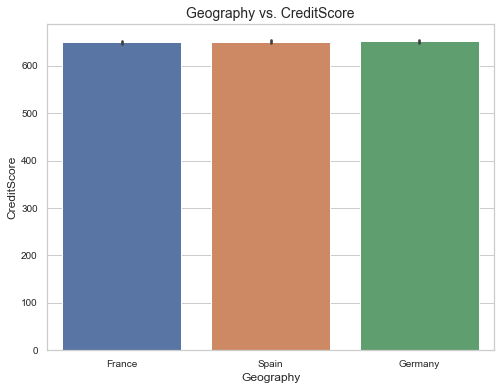

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Geography', y='CreditScore', data=df_bank)
plt.xlabel('Geography', fontsize=12)
plt.ylabel('CreditScore', fontsize=12)
plt.title('Geography vs. CreditScore', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

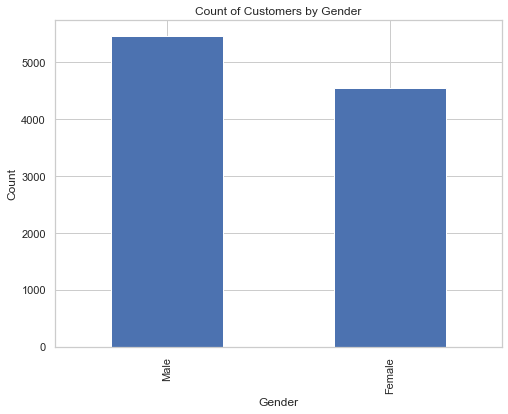

In [30]:
plt.figure(figsize=(8, 6))
df_bank['Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Customers by Gender')
plt.show()

In [31]:
df_bank['Exited_Y'] = df_bank['Exited'].apply(lambda arg: 1 if arg == 'Yes' else 0)
df_bank['Exited_Y']

RowNumber
1        1
2        0
3        1
4        0
5        0
        ..
9998     1
9999     1
9999     1
10000    0
10000    0
Name: Exited_Y, Length: 10002, dtype: int64

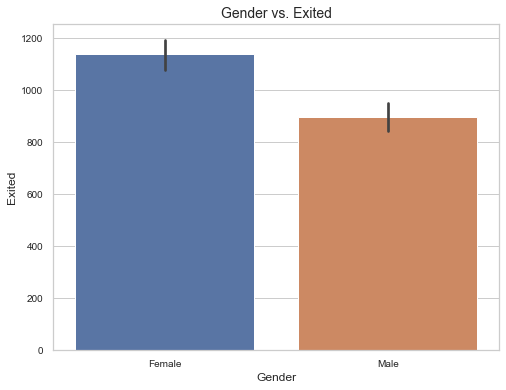

In [32]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Gender', y='Exited_Y', data=df_bank, estimator=sum)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Exited', fontsize=12)
plt.title('Gender vs. Exited', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

the data for male customers is higher than that of a female which means that the bank good use some techniques to capture more male customers and they could set their marketing techniques accordingly.

In the second graph, get to know that larger female population has exceted as compared to male population so considering gender as our feature would be an important parameter while we are training a model.

This graph also shows that the bank should do something to retain their female population.

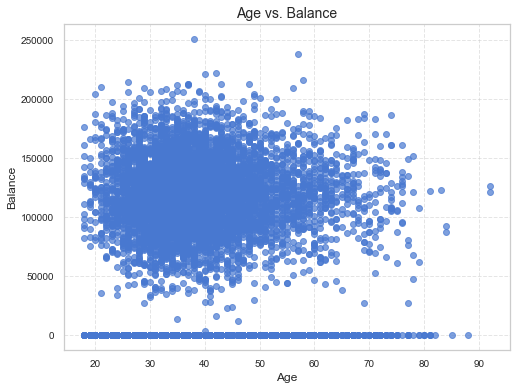

In [33]:
# Set plot style
sns.set_style("whitegrid")

# Set color palette
color_palette = sns.color_palette("muted")

# Scatter Plot - Age vs. Balance
plt.figure(figsize=(8, 6))
plt.scatter(data['Age'], df_bank['Balance'], color=color_palette[0], alpha=0.7)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Balance', fontsize=12)
plt.title('Age vs. Balance', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

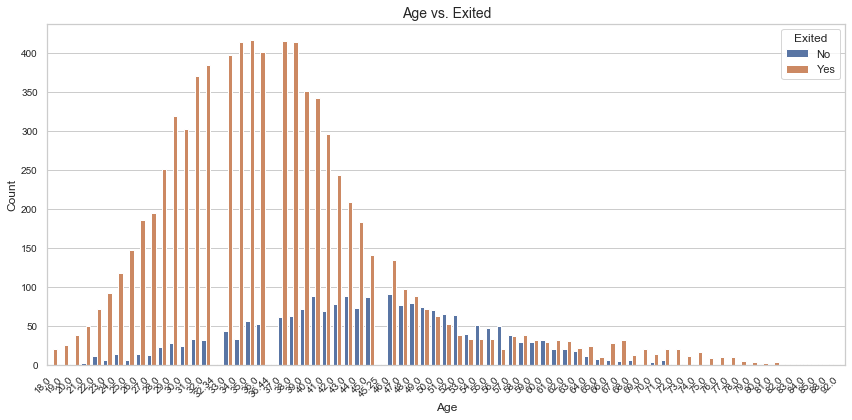

In [34]:
# Count Plot - Age vs. Exited
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Age', hue='Exited', data=df_bank)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Age vs. Exited', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(title='Exited', labels=['No', 'Yes'])

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

From this graph we understand age distribution. It also helps us understand customer attrition that various with age.

For example if a certain age group consistently shows higher churn rates it means that that age may player use role in customer retention. 

It also helps us understand the customer segmentation based on the age.

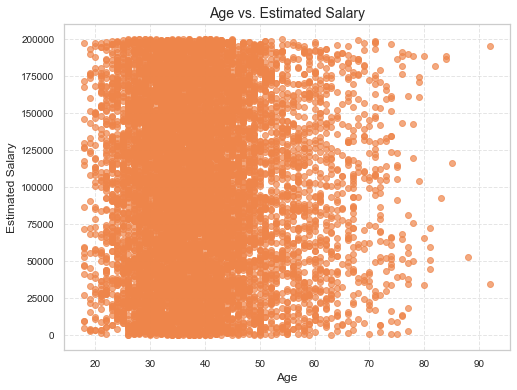

In [35]:
# Scatter Plot - Age vs. Estimated Salary
plt.figure(figsize=(8, 6))
plt.scatter(data['Age'], data['EstimatedSalary'], color=color_palette[1], alpha=0.7)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Estimated Salary', fontsize=12)
plt.title('Age vs. Estimated Salary', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

This is same like the graph we plotted above,
most of the data is completely scattered and we do not see any particular
relationship getting out of age and estimated salary. So, considering EstimatedSalary as a feature might not be needed.



<Figure size 576x432 with 0 Axes>

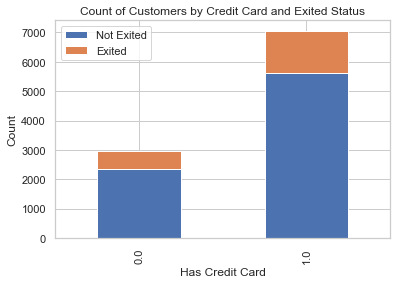

In [36]:
plt.figure(figsize=(8, 6))
data.groupby(['HasCrCard', 'Exited'])['Exited'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.title('Count of Customers by Credit Card and Exited Status')
plt.legend(['Not Exited', 'Exited'])
plt.show()

The graph allows us to analyze whether having a credit card has any correlation with customer attrition.

We can assess whether customers with or without a credit card show higher rates of churn.



<Figure size 576x432 with 0 Axes>

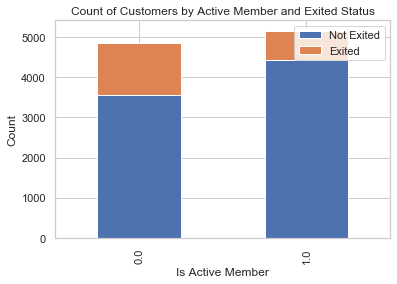

In [37]:
plt.figure(figsize=(8, 6))
data.groupby(['IsActiveMember', 'Exited'])['Exited'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Is Active Member')
plt.ylabel('Count')
plt.title('Count of Customers by Active Member and Exited Status')
plt.legend(['Not Exited', 'Exited'])
plt.show()

The person who is the member is is less likely to exit, which shows an interesting relation from a bank's view. The count for members and non members is roughly the same, but non members has higher exit count.



# After EDA, we get some important features that affected our target variable, like Age, Active Member, Geography and Gender.

# Predicted feature vs numerical features

# numerical vs Exited

note:

We can see number of differences between customers that exited and customers that didn't. 
It seems that older customers tend to churn more.


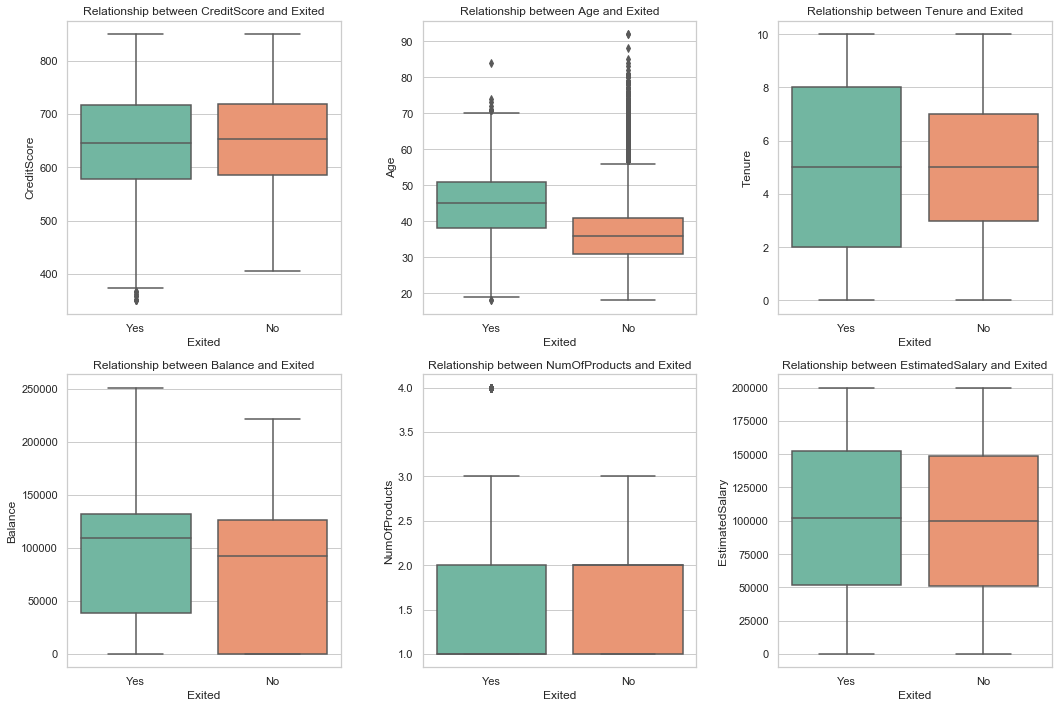

In [38]:
#Predicted feature vs numerical features

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Define numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the numerical features to create plots
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_bank, x='Exited', y=feature, palette='Set2')
    plt.title(f'Relationship between {feature} and Exited')
    plt.xlabel('Exited')
    plt.ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

# Target variable vs categorical predictors


Note:

-We can see that the odds ratio for customers that exited vs not exited is higher in Germany, meaning that Geography 
can help us understand some of the reason for customer churn.


-We can see that the odds ratio for customers that exited vs not exited is higher in the female group (Gender), meaning that Gender can help us understand some of the reason for customer churn (More women leave the bank).

---------------------------------------------------

###3) Pre-Processing Mind Map:


a) Detect & Handle Duplicates


b) train_test_split


c) Detect & Handle NaNs


d) Detect & Handle Outliers

e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])

f) Imbalanced: X_train_resampled

g) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled

---------------------------------------------------------------------------------------------------

step 1:

Are there any duplicate rows in the dataset?

In [39]:
import pandas as pd

# Check for duplicates
duplicates = df_bank.duplicated().sum()
duplicates

2

#there are duplicates

step 2:

In [40]:
# Remove duplicates
df_bank = df_bank.drop_duplicates()


step 3:
    
Train-Test Split

In [41]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_bank.drop(columns=['Exited'])
y = df_bank['Exited']

# Split the dataset (common split is 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: 

Detect & Handle NaNs

In [42]:
df_bank.isna().sum()

Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
Exited_Y           0
dtype: int64

In [43]:
# Null values in dataset
train_null = X_train.isnull().sum().sum()
test_null = X_test.isnull().sum().sum()

print(f"Null count in Training Data: {train_null}")
print(f"Null count in Test Data: {test_null}")

Null count in Training Data: 3
Null count in Test Data: 1


step 5:
#NaNs are found

In [50]:
# Drop NaNs from training and test sets
X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

Step 6:

Detect & Handle Outliers


In [70]:
Q1 = np.percentile(X_train, 25)  
Q3 = np.percentile(X_train, 75)  
IQR = Q3 - Q1

outliers = X_train[(X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))]

TypeError: '<' not supported between instances of 'float' and 'str'

step 7: 
Handle Outliers


In [85]:
import numpy as np  
import matplotlib.pyplot as plt  

def detect_and_handle_outliers(X_train, X_test):
    Q1 = np.percentile(X_train, 25)  
    Q3 = np.percentile(X_train, 75)  
    IQR = Q3 - Q1
    
    
    outliers = X_train[(X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))]
    
    
    plt.boxplot(X_train)  
    plt.title('Boxplot of Training Data')  
    plt.show()
    
    
    X_train_clean = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR)))]  
  
    plt.boxplot(X_train_clean)  
    plt.title('Boxplot of Cleaned Training Data')  
    plt.show()  
  
    Q1_test = np.percentile(X_test, 25)  
    Q3_test = np.percentile(X_test, 75)  
    IQR_test = Q3_test - Q1_test  
  
   outliers_test = X_test[(X_test < (Q1_test - 1.5 * IQR_test)) | (X_test > (Q3_test + 1.5 * IQR_test))]  
  
   X_test_clean = X_test[~((X_test < (Q1_test - 1.5 * IQR_test)) | (X_test > (Q3_test + 1.5 * IQR_test)))]  
  
   plt.boxplot(X_test_clean)  
    plt.title('Boxplot of Cleaned Test Data')  
    plt.show()  
  
   return X_train_clean, X_test_clean


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [86]:
X_train_clean, X_test_clean = detect_and_handle_outliers(X_train, X_test)


TypeError: '<' not supported between instances of 'float' and 'str'

In [82]:
import numpy as np  
import matplotlib.pyplot as plt  
  
def detect_and_handle_outliers(X_train, X_test):
    Q1 = np.percentile(X_train, 25)  
    Q3 = np.percentile(X_train, 75)  
    IQR = Q3 - Q1  
  
   outliers = X_train[(X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))]  
  
   plt.boxplot(X_train)
    plt.title('Boxplot of Training Data')
    plt.show()  
  
   X_train_clean = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR)))]  
  
   plt.boxplot(X_train_clean)  
    plt.title('Boxplot of Cleaned Training Data')  
    plt.show()
    
    Q1_test = np.percentile(X_test, 25)  
    Q3_test = np.percentile(X_test, 75)  
    IQR_test = Q3_test - Q1_test  
  
   outliers_test = X_test[(X_test < (Q1_test - 1.5 * IQR_test)) | (X_test > (Q3_test + 1.5 * IQR_test))]  
  
   X_test_clean = X_test[~((X_test < (Q1_test - 1.5 * IQR_test)) | (X_test > (Q3_test + 1.5 * IQR_test)))]  
  
   plt.boxplot(X_test_clean)  
    plt.title('Boxplot of Cleaned Test Data')  
    plt.show()  
  
   return X_train_clean, X_test_clean  
  



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

step 8 :
Encoding - How many unique values do categorical features have ?

In [51]:
target = ['Exited']
X = df_bank.drop(target, axis=1)
y = df_bank['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#validation
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 12), (2000, 12), (8000,), (2000,))

One-Hot Encoding for Nominal Categorical Features:

In [52]:
#relevant categorical features
nominal_cat_feats = ['Gender', 'Geography']

In [53]:
encoder = OneHotEncoder(sparse=False)
nominal_mat = encoder.fit_transform(X_train[nominal_cat_feats])
nominal_df = pd.DataFrame(nominal_mat,
                          columns=encoder.get_feature_names_out(),
                          index=X_train.index)

X_train = X_train.drop(columns=nominal_cat_feats)
X_train = pd.concat([X_train, nominal_df],axis=1)

In [54]:
nominal_mat_test = encoder.transform(X_test[nominal_cat_feats])
nominal_df_test = pd.DataFrame(nominal_mat_test,
                               columns=encoder.get_feature_names_out(),
                               index=X_test.index)

X_test = X_test.drop(columns=nominal_cat_feats)
X_test = pd.concat([X_test, nominal_df_test],axis=1)


In [55]:
nominal_df_test

,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Geography_nan
RowNumber,,,,,,
5936,0.0,1.0,0.0,0.0,1.0,0.0
7811,1.0,0.0,0.0,1.0,0.0,0.0
8939,0.0,1.0,0.0,0.0,1.0,0.0
71,0.0,1.0,0.0,1.0,0.0,0.0
2513,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5718,1.0,0.0,1.0,0.0,0.0,0.0
9452,0.0,1.0,0.0,0.0,1.0,0.0
4120,0.0,1.0,1.0,0.0,0.0,0.0


In [56]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [63]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']

for col in scale_cols:
    min_value = X_train[col].min()
    max_value = X_train[col].max()
    X_train[col+"_scaled"] = (X_train[col] - min_value) / (max_value - min_value)
    X_test[col+"_scaled"] = (X_test[col] - min_value) / (max_value - min_value)

step 10: Handle Class Imbalance



In [64]:
# Check class distribution
class_distribution = y.value_counts()
class_distribution

No     7963
Yes    2037
Name: Exited, dtype: int64

Step 11: Resampling

In [89]:
from imblearn.over_sampling import SMOTE


In [90]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'Griffin'

In [91]:
X_train

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited_Y,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Geography_nan,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled
RowNumber,,,,,,,,,,,,,,,,,,,,
7374,Griffin,663,37.0,7,143625.83,2,0.0,1.0,176487.05,0,0.0,1.0,0.0,1.0,0.0,0.0,0.256757,0.626,0.572447,0.882462
2883,McKay,551,37.0,3,0.00,2,1.0,1.0,50578.40,0,0.0,1.0,1.0,0.0,0.0,0.0,0.256757,0.402,0.000000,0.252858
8717,Nwachinemelu,565,38.0,5,0.00,2,0.0,1.0,80630.32,0,0.0,1.0,1.0,0.0,0.0,0.0,0.270270,0.430,0.000000,0.403132
7028,Sal,464,37.0,4,155994.15,1,0.0,0.0,143665.44,0,0.0,1.0,0.0,1.0,0.0,0.0,0.256757,0.228,0.621743,0.718338
7520,Castiglione,583,42.0,7,0.00,2,1.0,0.0,144039.05,0,1.0,0.0,1.0,0.0,0.0,0.0,0.324324,0.466,0.000000,0.720206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8555,Chandler,603,24.0,3,0.00,1,1.0,1.0,198826.03,1,1.0,0.0,1.0,0.0,0.0,0.0,0.081081,0.506,0.000000,0.994167
7852,Lavrentyev,758,68.0,6,112595.85,1,1.0,0.0,35865.44,1,0.0,1.0,0.0,1.0,0.0,0.0,0.675676,0.816,0.448771,0.179286
9256,Rapuluchukwu,847,41.0,3,101543.51,4,1.0,0.0,16025.17,1,1.0,0.0,0.0,1.0,0.0,0.0,0.310811,0.994,0.404720,0.080076


In [87]:
X_train_resampled

NameError: name 'X_train_resampled' is not defined

1. What is the overall churn rate?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate churn rate
total_customers = len(df_bank)
churned_customers = df_bank['Exited']
churn_rate = churned_customers / total_customers * 100

print(f"Overall Churn Rate: {churn_rate:.2f}%")

plt.figure(figsize=(6, 4))
plt.bar(['Churned', 'Stayed'], [churned_customers, total_customers - churned_customers], color=['red', 'green'])
plt.title('Overall Churn Rate')
plt.ylabel('Number of Customers')
plt.show()

2. How does churn rate vary by geography?

In [ ]:
# Churn rate by geography
churn_by_geo = df_bank.groupby('Geography')['Exited'].mean() * 100


plt.figure(figsize=(8, 5))
churn_by_geo.plot(kind='bar', color='skyblue')
plt.title('Churn Rate by Geography')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.show()

3)What is the average age of customers who churn versus those who stay?

In [ ]:
# Calculate average age for churned and non-churned customers
avg_age_churned = df_bank[df_bank['Exited'] == 1]['Age'].mean()
avg_age_stayed = df_bank[df_bank['Exited'] == 0]['Age'].mean()

print("Average Age of Churned Customers:", avg_age_churned)
print("Average Age of Stayed Customers:", avg_age_stayed)

In [ ]:
# Average age of customers who churn vs. those who stay
average_age = df_bank.groupby('Exited')['Age'].mean()
print("Average Age of Customers:")
print(average_age)

In [ ]:
4) How does credit score affect the likelihood of churn?

In [ ]:
# Churn rate based on credit score
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='CreditScore', data=df_bank)
plt.title('Credit Score vs. Churn')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Credit Score')
plt.show()

In [ ]:
5)What is the relationship between balance and churn?
# Create a scatter plot to visualize the relationship
plt.scatter(df_bank['Balance'], df_bank['Exited'])
plt.xlabel('Balance')
plt.ylabel('Exited')
plt.title('Balance vs. Churn')
plt.show()

In [ ]:
6)How does the number of products a customer has relate to churn?


In [ ]:
# Churn rate based on the number of products
products_churn = df_bank.groupby('NumOfProducts')['Exited'].mean() * 100
print("Churn Rate by Number of Products:")
print(products_churn)

In [ ]:
7)Is there a difference in churn rates between genders?


In [ ]:
# Churn rate by gender
churn_by_gender = df_bank.groupby('Gender')['Exited'].mean() * 100
print("Churn Rate by Gender:")
print(churn_by_gender)

In [ ]:
8)What is the impact of being an active member on churn?


In [ ]:
# Churn rate based on being an active member
churn_by_active_member = df_bank.groupby('IsActiveMember')['Exited'].mean() * 100
print("Churn Rate by Active Membership:")
print(churn_by_active_member)

In [ ]:
9)How does tenure with the bank relate to churn?


In [ ]:
# Churn rate based on tenure
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='Tenure', data=df_bank)
plt.title('Tenure vs. Churn')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Tenure (Years)')
plt.show()

In [ ]:
10)Are high estimated salaries associated with lower churn rates? 

In [ ]:
# Churn rate based on estimated salary
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df_bank)
plt.title('Estimated Salary vs. Churn')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Estimated Salary')
plt.show()

In [ ]:
# Create a scatter plot to visualize the relationship
plt.scatter(df_bank['EstimatedSalary'], df_bank['Exited'])
plt.xlabel('Estimated Salary')
plt.ylabel('Exited')
plt.title('Estimated Salary vs. Churn')
plt.show()